<a href="https://colab.research.google.com/github/Omarnot2far/projects/blob/main/learn_freCodeCamp_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [16]:
df = pd.read_csv('/content/wine-reviews.csv', usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129908 non-null  object 
 1   description  129971 non-null  object 
 2   points       129971 non-null  int64  
 3   price        120975 non-null  float64
 4   variety      129970 non-null  object 
 5   winery       129971 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.9+ MB


In [21]:
#drop nan value from description &	points

df = df.dropna(subset=['description', 'points'])

In [7]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [19]:
df.country.value_counts()

US                        54504
France                    22093
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4472
Argentina                  3800
Austria                    3345
Australia                  2329
Germany                    2165
New Zealand                1419
South Africa               1401
Israel                      505
Greece                      466
Canada                      257
Hungary                     146
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Slovenia                     87
Georgia                      86
England                      74
Croatia                      73
Mexico                       70
Moldova                      59
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine                      14
Serbia  

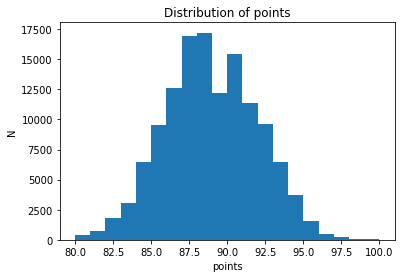

In [22]:
plt.hist(df.points, bins=20)
plt.title('Distribution of points')
plt.ylabel('N')
plt.xlabel('points')
plt.show()

In [23]:
#lets put the points in low or high tier to check the points of wine rating

df['label']= (df.points >= 90).astype(int)
df = df[['description', 'points', 'label']]

In [27]:
df['label'].value_counts()

0    80926
1    49045
Name: label, dtype: int64

In [28]:
df

,description,points,label
0,"Aromas include tropical fruit, broom, brimston...",87,0
1,"This is ripe and fruity, a wine that is smooth...",87,0
2,"Tart and snappy, the flavors of lime flesh and...",87,0
3,"Pineapple rind, lemon pith and orange blossom ...",87,0
4,"Much like the regular bottling from 2012, this...",87,0
...,...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,90,1
129967,Citation is given as much as a decade of bottl...,90,1
129968,Well-drained gravel soil gives this wine its c...,90,1
129969,"A dry style of Pinot Gris, this is crisp with ...",90,1


In [30]:
# put this into training, validation, testing data set

train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)),int(0.9*len(df))])

In [31]:
len (train), len(val), len(test)

(103976, 12997, 12998)

In [32]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [33]:
train_data =  df_to_dataset(train)
valid_data =  df_to_dataset(val)
test_data =  df_to_dataset(test)

In [35]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'This is a good deal for wine of this quality. Shy on the nose at first, it soon opens into a bevy of thick, meaty, smooth and rugged expression, dotted in a landscape of chocolate and bacon. Grippy tannin give way to more chocolate and welcome dots of white pepper.',
        b'Structured with firm, sticky tannin, this wine is built to age and impress over time, dusted with mocha and spicy black cherry flavor. Moderate in oak, it strikes a balance between its fruit and savory elements, softening in the glass.',
        b'A very pretty, opulent floral nose with hints of spice lead on this Hungarian sparkler. On the palate, it has a clean, minerally flavor that lacks some of the dimension and finesse that the nose would lead one to expect. A good food wine, though\xe2\x80\x94and fun. Imported by MHW Ltd.',
        ...,
        b'Even at four years of age, this shows great purity of fruit. Black cherries laced with garrigue mark th

In [36]:
# tensorflow hub --- this model to text clssification
# use text embedding to convert sentence to number
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)



In [37]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.2128834 , -0.22989334,  0.14039123, ..., -0.05629087,
        -0.21994777,  0.25129807],
       [ 0.49115708, -0.05150187, -0.05346084, ..., -0.09916516,
        -0.08232529,  0.08697565],
       [ 0.3667739 , -0.05131549,  0.15355274, ..., -0.06601186,
         0.13455208,  0.07156566],
       ...,
       [ 0.28758237,  0.06884563, -0.05143021, ..., -0.1439269 ,
        -0.29224864, -0.00057242],
       [ 0.32476082, -0.26230192, -0.11457163, ...,  0.07134616,
        -0.24856402, -0.04362237],
       [-0.03064097, -0.08042969, -0.12193748, ...,  0.04139532,
        -0.03102989,  0.09249575]], dtype=float32)>

In [38]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [40]:
model.evaluate(train_data)

102/102 [==============================] - 2s 12ms/step - loss: 0.7011 - accuracy: 0.4649


[0.7011283040046692, 0.4649149775505066]

In [41]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 10ms/step - loss: 0.7008 - accuracy: 0.4652


[0.7007672786712646, 0.4651842713356018]

In [42]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 127s 1s/step - loss: 0.6279 - accuracy: 0.6482 - val_loss: 0.4905 - val_accuracy: 0.7842
Epoch 2/5
102/102 [==============================] - 122s 1s/step - loss: 0.4631 - accuracy: 0.7832 - val_loss: 0.3913 - val_accuracy: 0.8200
Epoch 3/5
102/102 [==============================] - 113s 1s/step - loss: 0.3946 - accuracy: 0.8282 - val_loss: 0.3745 - val_accuracy: 0.8241
Epoch 4/5
102/102 [==============================] - 112s 1s/step - loss: 0.3621 - accuracy: 0.8461 - val_loss: 0.3694 - val_accuracy: 0.8291
Epoch 5/5
102/102 [==============================] - 113s 1s/step - loss: 0.3359 - accuracy: 0.8589 - val_loss: 0.3731 - val_accuracy: 0.8292


THIS IS overfitting problem if you see the validation and validation accuracy.
**so we use dropout layer in above**

In [43]:
model.evaluate(test_data)

13/13 [==============================] - 2s 157ms/step - loss: 0.3881 - accuracy: 0.8249


[0.38811782002449036, 0.8248961567878723]

**recreate this model with LSTM = Long Short-Term Memory layer**

In [44]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [45]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [46]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [48]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 2s 177ms/step - loss: 0.6939 - accuracy: 0.4120


[0.6939213275909424, 0.41201815009117126]

In [49]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 53s 451ms/step - loss: 0.5442 - accuracy: 0.7120 - val_loss: 0.3777 - val_accuracy: 0.8264
Epoch 2/5
102/102 [==============================] - 46s 447ms/step - loss: 0.3679 - accuracy: 0.8373 - val_loss: 0.3529 - val_accuracy: 0.8390
Epoch 3/5
102/102 [==============================] - 48s 471ms/step - loss: 0.3490 - accuracy: 0.8460 - val_loss: 0.3572 - val_accuracy: 0.8417
Epoch 4/5
102/102 [==============================] - 45s 440ms/step - loss: 0.3413 - accuracy: 0.8491 - val_loss: 0.3478 - val_accuracy: 0.8409
Epoch 5/5
102/102 [==============================] - 46s 450ms/step - loss: 0.3353 - accuracy: 0.8510 - val_loss: 0.3524 - val_accuracy: 0.8393


In [50]:
model.evaluate(test_data)

13/13 [==============================] - 3s 235ms/step - loss: 0.3608 - accuracy: 0.8381


[0.3607807755470276, 0.838128924369812]